## 베이스라인 모델 : 단순 회귀
- 목적
    - 비교를 위한 베이스라인 모델 생성
    - 베이스라인 : 비교 대상이 될 모델
- 핵심
    - Target 값의 분포를 찍어보고 => 몰려있다면 Log
- 다루는 내용
    - `Target` 분포 확인
    - Simple Linear Regression


In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='nycproject-297915' 

### 전처리

In [3]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)

SELECT 
    zip_code,
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    EXTRACT(MONTH FROM pickup_datetime) AS month,
    EXTRACT(DAY FROM pickup_datetime) AS day,
    CAST(format_datetime('%u', pickup_datetime) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_datetime) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_datetime) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend,
    COUNT(*) AS cnt
FROM base_data 
GROUP BY zip_code, pickup_hour, month, day, weekday, hour, is_weekend
ORDER BY pickup_hour


"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id='nycproject-297915')

Wall time: 19.6 s


In [4]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(base_df[['zip_code']])
ohe_output = enc.transform(base_df[['zip_code']]).toarray()
ohe_df = pd.concat([base_df, pd.DataFrame(ohe_output, columns='zip_code_'+ enc.categories_[0])], axis=1)

In [5]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Linear Regerssion
- Baseline 모델
   

### Target 분포 확인

In [6]:
base_df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt
0,11217,2015-01-01,1,1,3,0,0,121
1,10153,2015-01-01,1,1,3,0,0,30
2,11415,2015-01-01,1,1,3,0,0,2
3,10165,2015-01-01,1,1,3,0,0,39
4,11374,2015-01-01,1,1,3,0,0,5


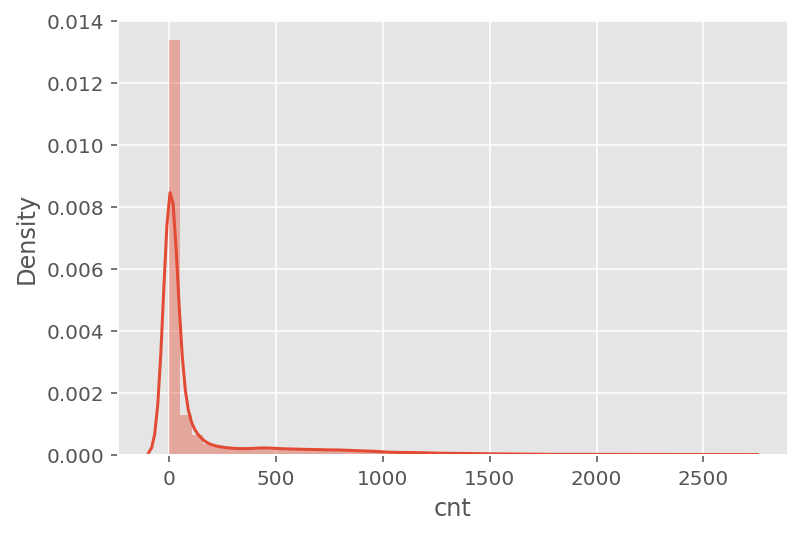

In [7]:
# 전체 분포
sns.distplot(base_df['cnt']);
#치우친 모양

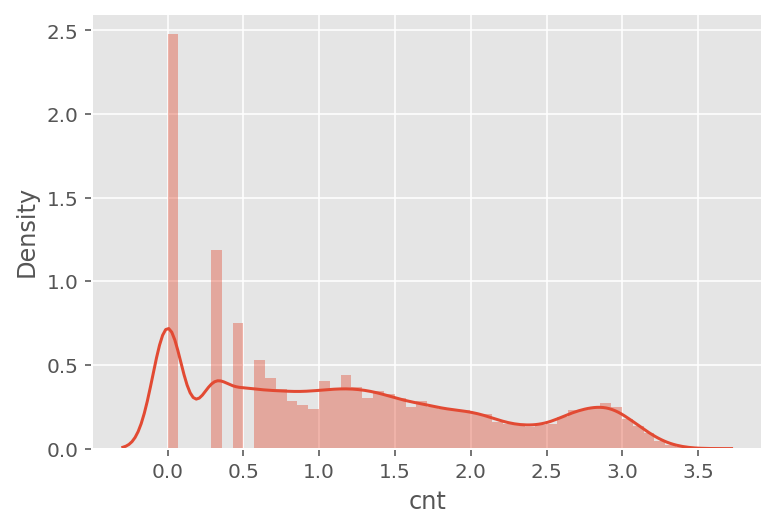

In [8]:
# 전체 분포 log화
sns.distplot(np.log10(base_df['cnt']));

### Widget으로 파악

In [9]:
def visualize_dist_by_zipcode(df, log=False):
    def view_images(zip_code):
        if log:
            data = np.log10(df.loc[df['zip_code'] == str(zip_code)]['cnt'])
        else:
            data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        ax = sns.distplot(data);
        ax.set_title(f'log is {log}, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [10]:
visualize_dist_by_zipcode(ohe_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

In [11]:
visualize_dist_by_zipcode(base_df, log=True)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

- 그냥 한번에 보도록 함수 수정

In [12]:
def visualize_dist_by_zipcode_at_the_same_time(df):
    def view_images(zip_code):
        fig, axs = plt.subplots(ncols=2, figsize=(15,5))

        raw_data = df.loc[df['zip_code'] == str(zip_code)]['cnt']
        log_data = np.log10(raw_data)
        ax1 = sns.distplot(raw_data, ax=axs[0]);
        ax2 = sns.distplot(log_data, ax=axs[1]);
        ax1.set_title(f'log is False, zip_code : {zip_code}')
        ax2.set_title(f'log is True, zip_code : {zip_code}')
    interact(view_images, zip_code=(10001, 10200))

In [13]:
visualize_dist_by_zipcode_at_the_same_time(base_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

- 분포를 보고 log를 취하기로 결정

- log_cnt 생성

In [14]:
base_df['log_cnt'] = np.log10(base_df['cnt'])

### Train / Test 나누기

In [15]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [16]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
65113,11374,2015-01-23 23:00:00,1,23,4,23,0,6,0.778151
65114,11421,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000
65115,11413,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000
65116,11432,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000
65117,10475,2015-01-23 23:00:00,1,23,4,23,0,1,0.000000


In [17]:
test_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,log_cnt
87015,10451,2015-01-31 23:00:00,1,31,5,23,1,3,0.477121
87016,10168,2015-01-31 23:00:00,1,31,5,23,1,22,1.342423
87017,10009,2015-01-31 23:00:00,1,31,5,23,1,1166,3.066699
87018,11373,2015-01-31 23:00:00,1,31,5,23,1,5,0.698970
87019,10044,2015-01-31 23:00:00,1,31,5,23,1,6,0.778151


- 사용하지 않을 컬럼 삭제

In [18]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [19]:
train_df.head(2)

,zip_code,month,day,weekday,hour,is_weekend,cnt,log_cnt
0,11217,1,1,3,0,0,121,2.082785
1,10153,1,1,3,0,0,30,1.477121


In [20]:
y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

In [21]:
x_train = train_df.copy()
x_test = test_df.copy()

### Simple Regression
- One Hot Encoding 없이 그냥

In [22]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.4313428 , 1.53142763, 0.50900929, ..., 1.8813229 , 0.70446331,
       1.85112489])

In [23]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

- mape,mae,mse 계산해주는 함수

In [27]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [28]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,428.415375,126.535552,95916.687733


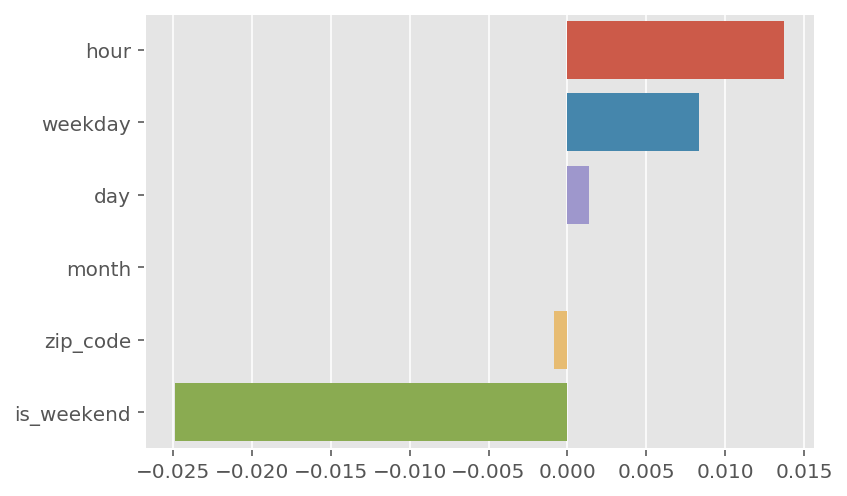

In [26]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

- is_weekend가 마이너스?

### One Hot Encoding

- One Hot Encoding을 사용해 Regression

In [29]:
ohe_df['log_cnt'] = np.log10(ohe_df['cnt'])
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

y_train_raw = train_df.pop('cnt')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('cnt')
y_test_log = test_df.pop('log_cnt')

x_train = train_df.copy()
x_test = test_df.copy()

In [30]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([1.0618639 , 0.5049634 , 0.90214539, ..., 2.64466619, 0.8987627 ,
       0.41451836])

In [31]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [32]:
test_df.head()

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.061864,11.530918,1.491362,31
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.504963,3.198626,0.477121,3
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.902145,7.982619,1.973128,94
65121,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.055263,11.356972,1.397940,25
65122,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.465131,291.830585,2.562293,365


In [33]:
test_df.head(3)

,month,day,weekday,hour,is_weekend,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10004,zip_code_10005,...,zip_code_13118,zip_code_13656,zip_code_13691,zip_code_14072,zip_code_14527,zip_code_14801,pred_log,pred_reverse,real_log,real_raw
65118,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.061864,11.530918,1.491362,31
65119,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.504963,3.198626,0.477121,3
65120,1,24,5,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.902145,7.982619,1.973128,94


In [34]:
# inf를 제외하기 위한 전처리
test_df = test_df[np.isfinite(test_df).all(1)]

In [35]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

,mape,mae,mse
score,244.738463,66.943699,27020.779948


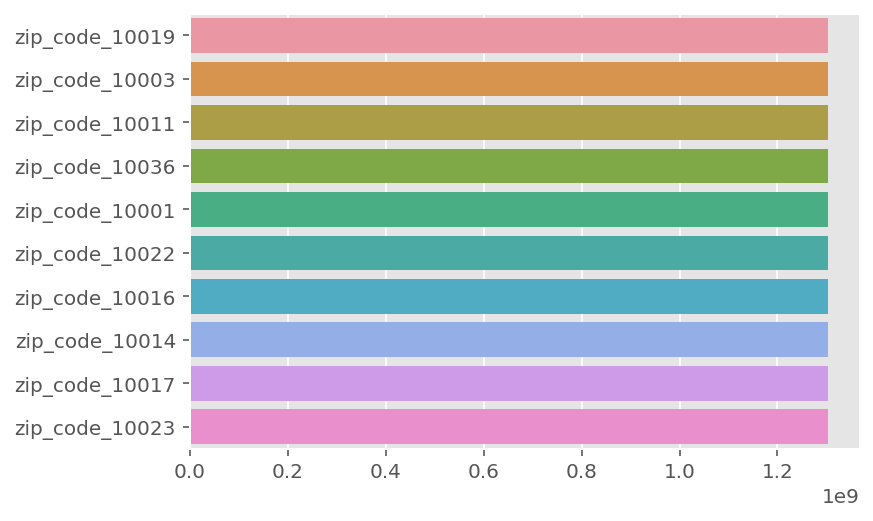

In [37]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);